In [124]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
from pathlib import Path
import seaborn as sns

import socket
import os

In [125]:
LOCAL_IP = socket.gethostbyname(socket.gethostname())
LOCAL_IP

'10.128.121.240'

In [126]:
#running spark
spark = (
    SparkSession
    .builder
    .master('k8s://https://10.32.7.103:6443')
    .config('spark.driver.host',LOCAL_IP)
    .config('spark.driver.bindAddress','0.0.0.0')
    .config('spark.executor.instances','2')
    .config('spark.executor.cores','2')
    .config('spark.cores.max','4')
    .config('spark.executor.memory','4g')
    .config('spark.sql.execution.arrow.enabled','true')
    .config('spark.kubernetes.namespace','ealekseeva-337108')
    .config('spark.kubernetes.container.image','node03.st:5000/spark-executor:ealekseeva-337108')
    .config('spark.kubernetes.container.image.pullPolicy', 'Always')
    .config('spark.kubernetes.executor.deleteOnTermination','false')
    .getOrCreate()
    )      

Read data

In [242]:
hdfs_data_dir = Path("hdfs://tmp/vshishkov-243998/project_data")
hdfs_currencies_dir = hdfs_data_dir / "currencies"

results = spark.read.option("multiline", True).option('escape', "\"").csv((hdfs_data_dir / "results.csv").as_posix())\
            .withColumnRenamed("_c0", "model")\
            .withColumnRenamed("_c1", "coin")\
            .withColumnRenamed("_c2", "MAE")\
            .orderBy('coin')

In [243]:
results_without_media = spark.read.option("multiline", True).option('escape', "\"").csv((hdfs_data_dir / "results_pure.csv").as_posix())\
            .withColumnRenamed("_c0", "model")\
            .withColumnRenamed("_c1", "coin")\
            .withColumnRenamed("_c2", "MAE")

In [244]:
results.printSchema()

root
 |-- model: string (nullable = true)
 |-- coin: string (nullable = true)
 |-- MAE: string (nullable = true)



In [245]:
results.show(36)

+--------------------+--------+------------------+
|               model|    coin|               MAE|
+--------------------+--------+------------------+
|    LinearRegression|aave-usd|  3.38909368783186|
|RandomForestRegre...|aave-usd| 12.17877014580313|
|    LinearRegression| ada-usd| 53.11460311310485|
|RandomForestRegre...| ada-usd|190.43318869553823|
|RandomForestRegre...| axs-usd| 10.97739364408831|
|    LinearRegression| axs-usd| 2.493182928765717|
|    LinearRegression| bnb-usd| 58.14166281459337|
|RandomForestRegre...| bnb-usd|115.42220129814977|
|    LinearRegression| btc-usd| 70.72158059752994|
|RandomForestRegre...| btc-usd|3669.0716867462606|
|    LinearRegression|doge-usd| 16.11117076953613|
|RandomForestRegre...|doge-usd|116.33106924286042|
|    LinearRegression| dot-usd| 6.954706975243569|
|RandomForestRegre...| dot-usd|11.225788108692702|
|RandomForestRegre...| fil-usd|42.683028006713684|
|    LinearRegression| fil-usd|11.821681003365297|
|    LinearRegression| icp-usd|

In [246]:
results_without_media.printSchema()

root
 |-- model: string (nullable = true)
 |-- coin: string (nullable = true)
 |-- MAE: string (nullable = true)



In [247]:
results_df = results.toPandas()
results_df['MAE'] = results_df.MAE.astype(float)

results_without_media_df = results_without_media.toPandas()
results_without_media_df['MAE'] = results_without_media_df.MAE.astype(float)

In [248]:
results_df["model"] = results_df["model"].replace({"LinearRegression": "LR_SM", "RandomForestRegressor": "RFR_SM"})
results_without_media_df["model"] = results_without_media_df["model"].replace({"LinearRegression": "LR", "RandomForestRegressor": "RFR"})
all_results = pd.concat([results_df, results_without_media_df])

In [209]:
group1 = ['ltc-usd','ada-usd','lrc-usd','bnb-usd','zil-usd','doge-usd', 'zil-usd']
group2 = ['bct-usd']
group3 = ['aave-usd','axs-usd','dot-usd','fil-usd','icp-usd','link-usd','rep-usd', 'uni1-usd', 'vet-usd', 'xmr-usd', 'xrp-usd']

Text(0.5, 1.0, 'MAE of training model based on social media data for btc-usd')

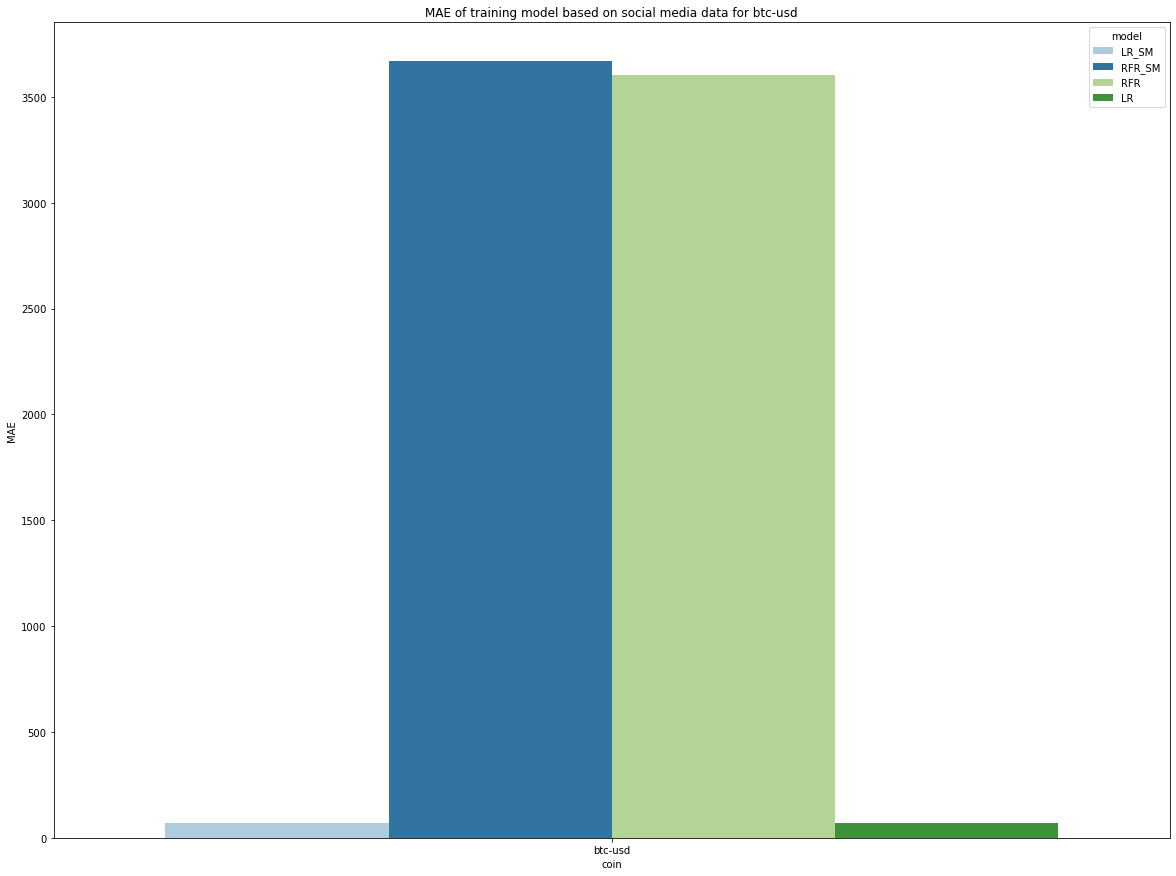

In [256]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=all_results[all_results.coin == 'btc-usd']["coin"], 
                 y=all_results[all_results.coin == 'btc-usd']["MAE"], 
                 hue=all_results[all_results.coin == 'btc-usd']["model"])
ax.set_title('MAE of training model based on social media data for btc-usd')

Text(0.5, 1.0, 'MAE of training model based on social media data')

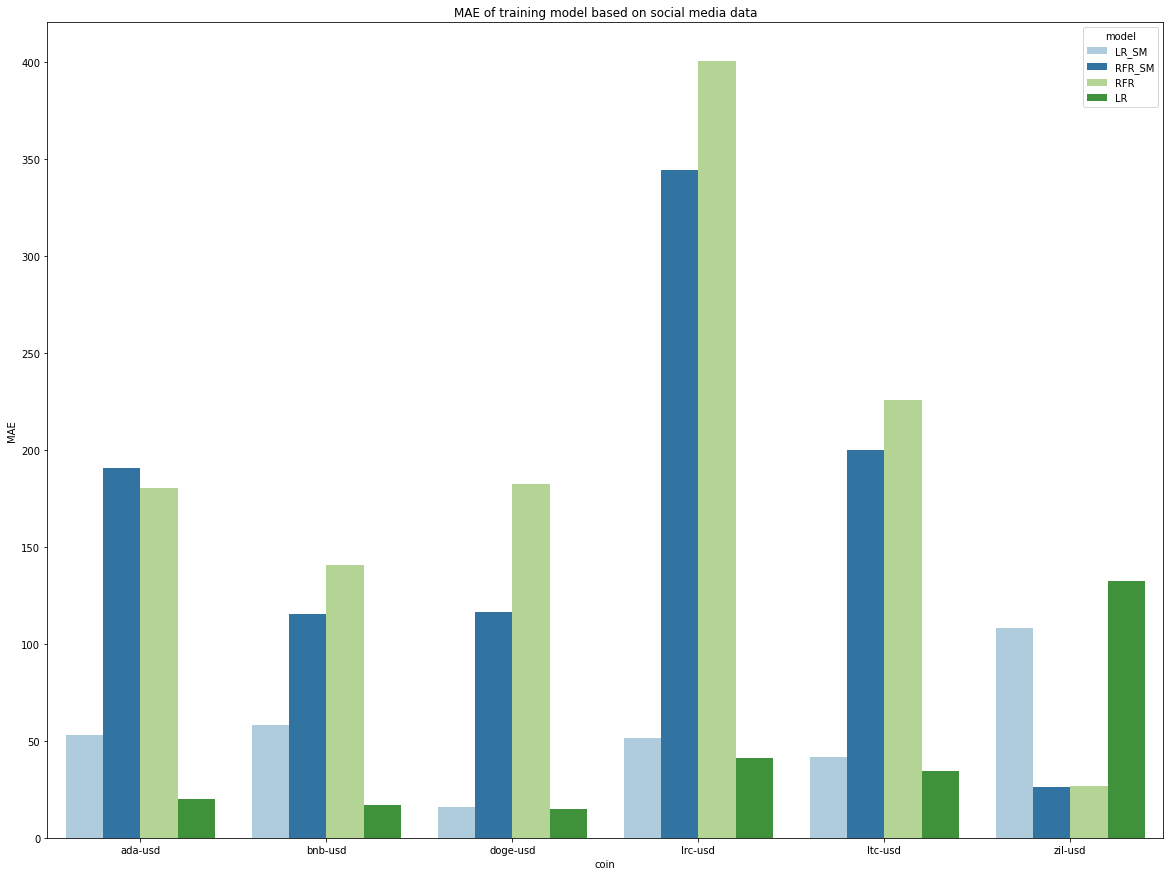

In [261]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=all_results[all_results.coin.isin(group1)]["coin"], 
                 y=all_results[all_results.coin.isin(group1)]["MAE"], 
                 hue=all_results[all_results.coin.isin(group1)]["model"])
ax.set_title('MAE of training model based on social media data')

Text(0.5, 1.0, 'MAE of training model based on social media data')

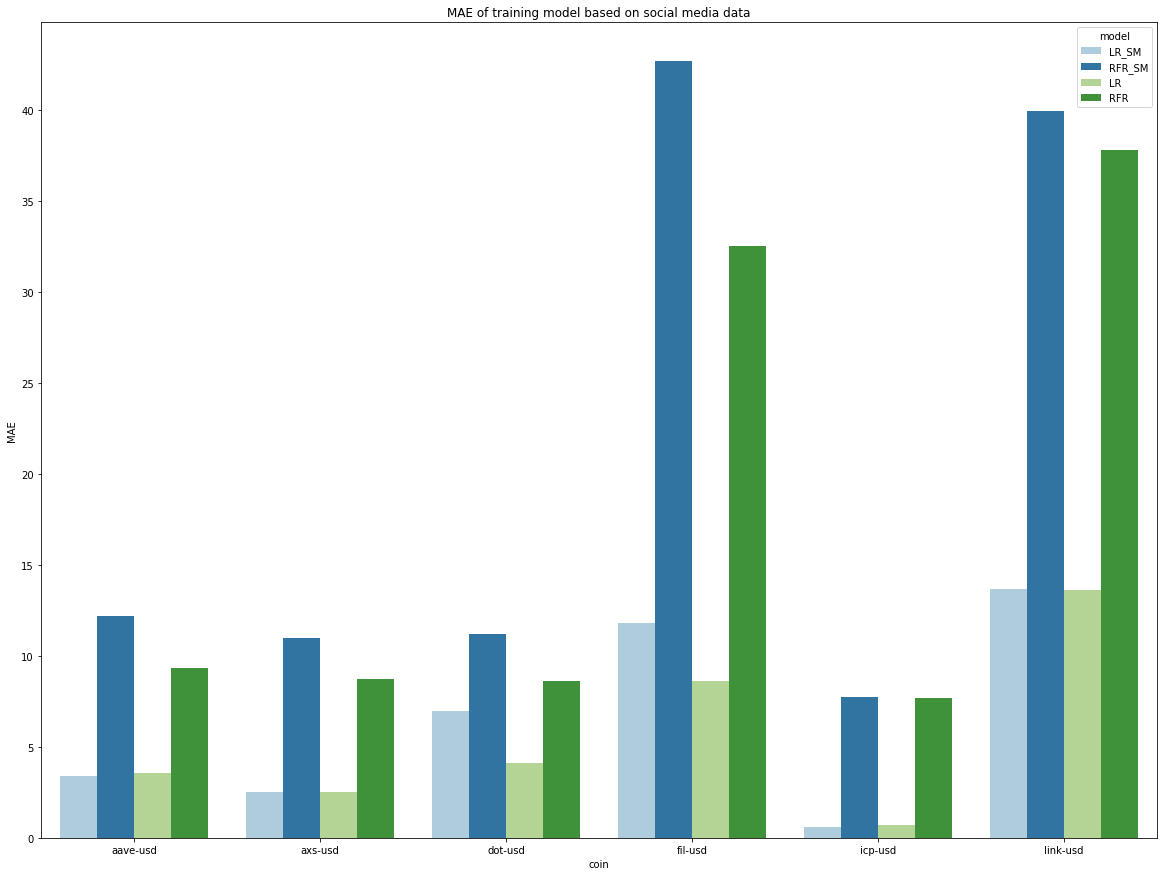

In [262]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=all_results[all_results.coin.isin(group3)]["coin"], 
                 y=all_results[all_results.coin.isin(group3)]["MAE"], 
                 hue=all_results[all_results.coin.isin(group3)]["model"])
ax.set_title('MAE of training model based on social media data')

In [265]:
spark.stop()